In [1]:
"""
----
Project setup and imports.
----
Explicitly add the project root to sys.path.
Imports from src/ work regardless of where the notebook is run.
Avoid fragile relative imports inside notebooks.
"""

import sys
from pathlib import Path
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root added to path:", project_root)

Project root added to path: /Users/sandy/protein_mutation_effects


In [2]:
"""
----
Load experiment configuration.
----
All experiment-wide settings are centralized in src.config for reproducibility.
"""

from src.config import (
    RANDOM_STATE,
    CSV_PATH,
    PROCESSED_PATH,
    SAMPLE_SIZE,
    USE_SAMPLE,
    SAVE_PROCESSED,
    DOWNSAMPLE
)

print("Config:", CSV_PATH, "SAMPLE:", USE_SAMPLE, SAMPLE_SIZE)

Config: /Users/sandy/protein_mutation_effects/data/DDG_DATA.csv SAMPLE: False 200000


In [3]:
"""
----
Load and clean mutation dataset.
----
Load raw DDG dataset.
Filter to required columns.
Clean mutation strings.
Derive a binary stabilizing label.
"""

from src.data_utils import load_and_clean_data

needed_cols = [
    'SUBSTITUTION',
    'DDG',
    'ORGANISM',
    'CONSERVATION',
    'B_FACTOR'
]

df = load_and_clean_data(
    CSV_PATH,
    needed_cols,
    use_sample=USE_SAMPLE,
    sample_size=SAMPLE_SIZE,
    processed_path=PROCESSED_PATH,
    random_state=RANDOM_STATE
)

print("Loaded rows:", len(df))

Final dataset size: 412411
Stabilizing label distribution:
stabilizing
True     0.776524
False    0.223476
Name: proportion, dtype: float64
Loaded rows: 412411


In [4]:
"""
----
Stratified train/test split.
----
Stratification ensures class imbalance ratio is preserved in both training and test sets.
"""

# Split df into train/test.
from src.train_utils import train_test_split_stratified_df

# Split DataFrame.
df_train, df_test = train_test_split_stratified_df(
    df,
    target_col="stabilizing",
    test_size=0.2,
    random_state=RANDOM_STATE
)

In [5]:
"""
----
Feature engineering.
----
Build a feature matrix consisting of:
    1) One-hot encoded WT and mutant amino acids.
    2) Numeric positional/structural features.
    3) AAindex-derived biochemical properties.
"""

from src.feature_utils import (
    build_base_features,
    build_aaindex_features_raw,
    fit_feature_scaler,
    apply_feature_scaler,
)

# Selected AAindex properties representing:
    # 1) Hydrophobicity.
    # 2) Secondary structure propensity.
    # 3) Volume.
    # 4) Polarity.
    # 5) H-bonding.
chosen_indices = [
    "KYTJ820101",
    "FAUJ880111",
    "CHAM810101",
    "GRAR740102",
    "HOPT810101"
]

# Base features.
X_train_base = build_base_features(df_train)
X_test_base  = build_base_features(df_test)

# AAindex features.
X_train_aa = build_aaindex_features_raw(df_train, "../data/aaindex1.txt", chosen_indices)
X_test_aa  = build_aaindex_features_raw(df_test, "../data/aaindex1.txt", chosen_indices)

# Combine features.
import pandas as pd

X_train = pd.concat([X_train_base, X_train_aa], axis=1)
X_test  = pd.concat([X_test_base, X_test_aa], axis=1)

# Labels.
y_train = df_train["stabilizing"].astype(int)
y_test  = df_test["stabilizing"].astype(int)

# Scale features.
scaler = fit_feature_scaler(X_train)
X_train = apply_feature_scaler(X_train, scaler)
X_test  = apply_feature_scaler(X_test, scaler)

# Check training set.
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Label distribution (train):\n", y_train.value_counts())
print("NaNs in X_train:", X_train.isna().sum().sum())

# Check test set.
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Label distribution (test):\n", y_test.value_counts())
print("NaNs in X_test:", X_test.isna().sum().sum())

X_train shape: (329928, 58)
y_train shape: (329928,)
Label distribution (train):
 stabilizing
1    256197
0     73731
Name: count, dtype: int64
NaNs in X_train: 0
X_test shape: (82483, 58)
y_test shape: (82483,)
Label distribution (test):
 stabilizing
1    64050
0    18433
Name: count, dtype: int64
NaNs in X_test: 0


In [6]:
"""
----
Handle class imbalance.
----
Either downsample majority class or compute class weights.
Class weighting is preferred to preserve all available data.
"""

from src.data_utils import apply_downsampling, compute_class_weights

if DOWNSAMPLE:
    df = apply_downsampling(df, random_state=RANDOM_STATE)
    print("After downsampling df shape:", df.shape)
    print("Label distribution:\n", df['stabilizing'].value_counts())

    X_base = build_base_features(df)
    print("X_base shape:", X_base.shape)

    max_indices = 50
    chosen_indices_safe = chosen_indices[:max_indices]
    
    aa_feats = build_aaindex_features_raw(
        df,
        "../data/aaindex1.txt",
        chosen_indices_safe
    )
    print("aa_feats shape:", aa_feats.shape)

    X = pd.concat([X_base.reset_index(drop=True),
                   aa_feats.reset_index(drop=True)],
                  axis=1)
    print("Final X shape after concat:", X.shape)

    y = df['stabilizing'].astype(int).reset_index(drop=True)

else:
    class_weight_dict = compute_class_weights(y_train)
    class_weight_dict = {
    int(k): float(v)
    for k, v in class_weight_dict.items()
    }

2026-01-27 15:20:59.047760: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2026-01-27 15:20:59.047788: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2026-01-27 15:20:59.047796: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
2026-01-27 15:20:59.047831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-27 15:20:59.047840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2026-01-27 15:20:59.435986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6020 - loss: 0.6853 - val_accuracy: 0.6080 - val_loss: 0.6554
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6228 - loss: 0.6470 - val_accuracy: 0.5179 - val_loss: 0.7049
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6115 - loss: 0.6714 - val_accuracy: 0.4747 - val_loss: 0.7839
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6031 - loss: 0.6933 - val_accuracy: 0.6244 - val_loss: 0.6527
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6028 - loss: 0.7283 - val_accuracy: 0.4380 - val_loss: 1.4188
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5880 - loss: 0.7877 - val_accuracy: 0.6327 - val_loss: 0.7342
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5928 - loss: 0.7893 - val_accuracy: 0.4441 - val_loss: 1.5789
2578/2578 ━━━━━━━━━━━━━━━━━━━━ 2s 902us/step


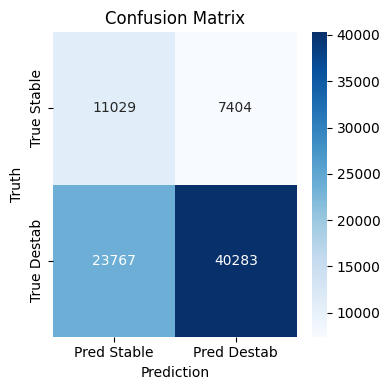

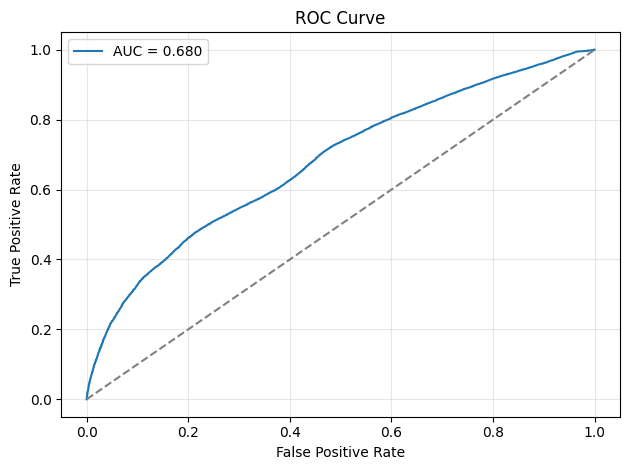

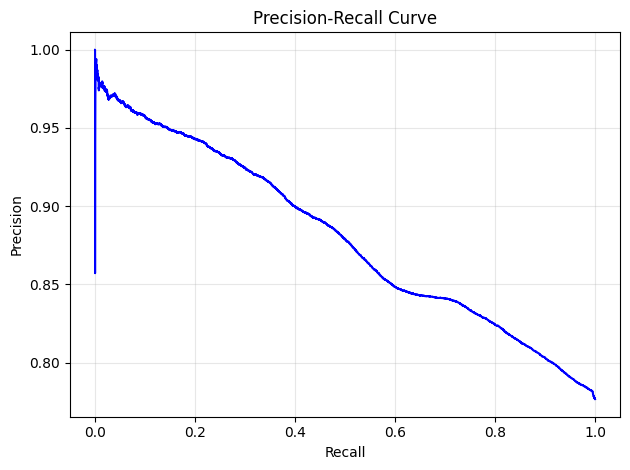

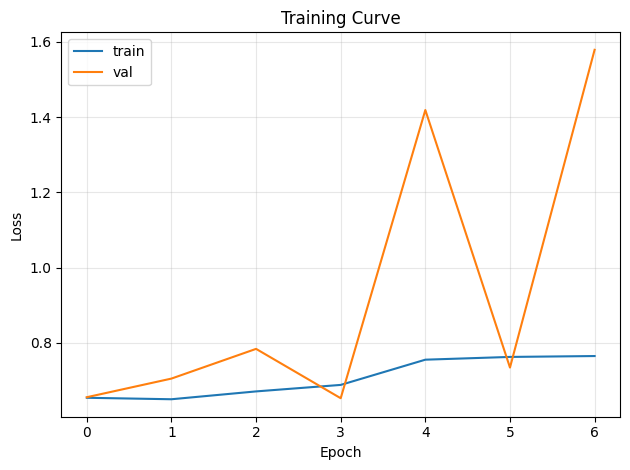

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,621 (186.02 KB)

 Trainable params: 15,873 (62.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,748 (124.02 KB)

Evaluation metrics:
accuracy: 0.6221
precision: 0.8447
recall: 0.6289
roc_auc: 0.6798


In [7]:
"""
----
Evaluate model and save results.
----
Compute metrics.
Save and display:
    1) Confusion matrix.
    2) ROC curve.
    3) PR curve.
    4) Training curve.
    5) Metrics JSON.
    6) Model summary TXT.
"""

from src.model_utils import build_nn
from src.analysis_utils import evaluate_and_report_model
from src.config import RANDOM_STATE
from tensorflow.keras.callbacks import EarlyStopping

# Build model.
model = build_nn(X_train.shape[1])

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Train fully-connected neural network using binary cross-entropy loss.
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=1024,
    verbose=1,
    callbacks=[early_stop],
    class_weight=class_weight_dict
)

# Evaluate, plot, save, and display all results.
results = evaluate_and_report_model(
    model,
    X_test,
    y_test,
    history=history,
    overwrite=True,
    show_plots=True
)

# Show metrics.
print("Evaluation metrics:")
for k, v in results["scores"].items():
    print(f"{k}: {v:.4f}")